#EXCIR methodology and code

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Step 1: Data Simulation
np.random.seed(42)  # For reproducibility
num_observations = 10000
num_features = 10  # 10 appliances
data = np.random.rand(num_observations, num_features) * 100  # Random data between 0 and 100

# Total hourly consumption as the sum of all appliances
total_consumption = data.sum(axis=1, keepdims=True)

# Standardize features
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)
total_consumption_scaled = scaler.fit_transform(total_consumption)

# Step 2: Sample Data
sample_indices = np.random.choice(np.arange(num_observations), size=3000, replace=False)
data_sampled = data_scaled[sample_indices]
total_sampled = total_consumption_scaled[sample_indices]

# Step 3: LSTM Model Setup
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        return out

def train_model(data, targets, model, epochs=10, batch_size=64):
    model.train()
    train_data = TensorDataset(torch.Tensor(data), torch.Tensor(targets))
    train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    for epoch in range(epochs):
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    print(f'Final loss: {loss.item()}')

# Prepare data for LSTM
X_train, X_test, y_train, y_test = train_test_split(data_scaled, total_consumption_scaled, test_size=0.2, random_state=42)
X_sample_train, X_sample_test, y_sample_train, y_sample_test = train_test_split(data_sampled, total_sampled, test_size=0.2, random_state=42)

# Initialize models
model_original = LSTMModel(input_dim=num_features, hidden_dim=50, num_layers=2, output_dim=1)
model_sampled = LSTMModel(input_dim=num_features, hidden_dim=50, num_layers=2, output_dim=1)

# Train models
train_model(X_train.reshape(-1, 1, num_features), y_train, model_original, epochs=50)
train_model(X_sample_train.reshape(-1, 1, num_features), y_sample_train, model_sampled, epochs=50)

# Step 4 and 5: Additional evaluation and visualization would follow as per your theoretical framework.


Final loss: 9.647239494370297e-05
Final loss: 0.0013158266665413976


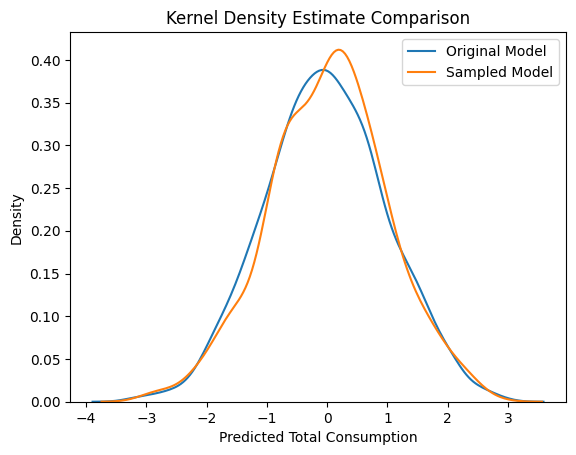

KL Divergence between original and sampled models: 0.004657193540364285


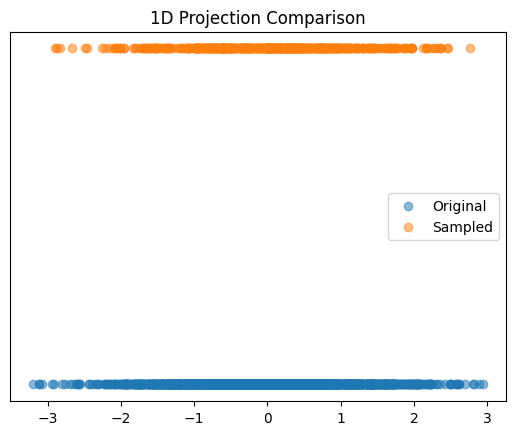

In [ ]:
import seaborn as sns
from scipy.stats import gaussian_kde, entropy

# Step 4: Evaluate Models
def evaluate_model(model, X_test):
    model.eval()
    with torch.no_grad():
        inputs = torch.Tensor(X_test)
        outputs = model(inputs).numpy().flatten()
    return outputs

# Get model predictions
orig_preds = evaluate_model(model_original, X_test.reshape(-1, 1, num_features))
sample_preds = evaluate_model(model_sampled, X_sample_test.reshape(-1, 1, num_features))



In [ ]:
# Step 5: Visualization and Statistical Analysis
def plot_kde(orig_preds, sample_preds):
    sns.kdeplot(orig_preds, label='Original Model')
    sns.kdeplot(sample_preds, label='Sampled Model')
    plt.title('Kernel Density Estimate Comparison')
    plt.xlabel('Predicted Total Consumption')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

plot_kde(orig_preds, sample_preds)

# Calculate and display KL divergence
def calculate_kl_divergence(p, q):
    p_density = gaussian_kde(p)
    q_density = gaussian_kde(q)
    x = np.linspace(min(p.min(), q.min()), max(p.max(), q.max()), 1000)
    p_pdf = p_density(x)
    q_pdf = q_density(x)
    return entropy(p_pdf, q_pdf)

kl_div = calculate_kl_divergence(orig_preds, sample_preds)
print(f"KL Divergence between original and sampled models: {kl_div}")

# Additional embedding and projection analysis
# For simplicity, let's use PCA for dimensionality reduction as a form of projection
from sklearn.decomposition import PCA

def project_and_compare(data1, data2):
    pca = PCA(n_components=1)  # Reduce to 1D for simplicity
    data1_projected = pca.fit_transform(data1.reshape(-1, 1))
    data2_projected = pca.transform(data2.reshape(-1, 1))
    plt.figure()
    plt.scatter(data1_projected, np.zeros_like(data1_projected), alpha=0.5, label='Original')
    plt.scatter(data2_projected, np.zeros_like(data2_projected) + 0.1, alpha=0.5, label='Sampled')
    plt.title('1D Projection Comparison')
    plt.yticks([])
    plt.legend()
    plt.show()

project_and_compare(orig_preds, sample_preds)


#KDE plot for feature uncertainity

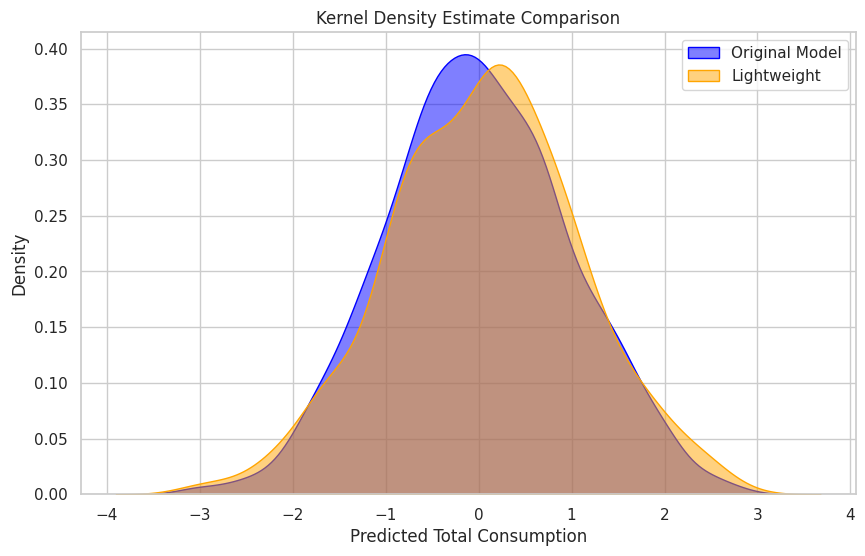

KL Divergence between original and sampled models: 0.007771090276786786


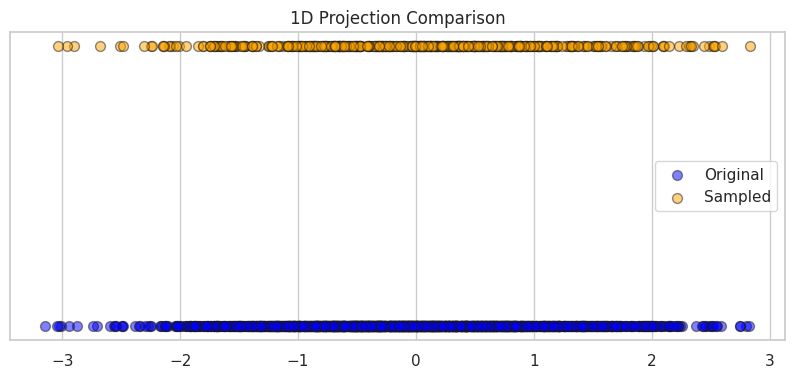

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from scipy.stats import gaussian_kde, entropy

# Improve the overall aesthetics
sns.set(style='whitegrid')

def evaluate_model(model, X_test):
    model.eval()
    with torch.no_grad():
        inputs = torch.Tensor(X_test)
        outputs = model(inputs).numpy().flatten()
    return outputs

# Evaluation of predictions
orig_preds = evaluate_model(model_original, X_test.reshape(-1, 1, num_features))
sample_preds = evaluate_model(model_sampled, X_sample_test.reshape(-1, 1, num_features))

def plot_kde(orig_preds, sample_preds):
    plt.figure(figsize=(10, 6))
    sns.kdeplot(orig_preds, label='Original Model', color='blue', fill=True, alpha=0.5)
    sns.kdeplot(sample_preds, label='Lightweight', color='orange', fill=True, alpha=0.5)
    plt.title('Kernel Density Estimate Comparison')
    plt.xlabel('Predicted Total Consumption')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

plot_kde(orig_preds, sample_preds)

def calculate_kl_divergence(p, q):
    p_density = gaussian_kde(p)
    q_density = gaussian_kde(q)
    x = np.linspace(min(p.min(), q.min()), max(p.max(), q.max()), 1000)
    p_pdf = p_density(x)
    q_pdf = q_density(x)
    return entropy(p_pdf, q_pdf)

kl_div = calculate_kl_divergence(orig_preds, sample_preds)
print(f"KL Divergence between original and sampled models: {kl_div}")

def project_and_compare(data1, data2):
    pca = PCA(n_components=1)  # Reduce to 1D for simplicity
    data1_projected = pca.fit_transform(data1.reshape(-1, 1))
    data2_projected = pca.transform(data2.reshape(-1, 1))
    plt.figure(figsize=(10, 4))
    plt.scatter(data1_projected, np.zeros_like(data1_projected), alpha=0.5, color='blue', edgecolor='k', s=50, label='Original')
    plt.scatter(data2_projected, np.zeros_like(data2_projected) + 0.1, alpha=0.5, color='orange', edgecolor='k', s=50, label='Sampled')
    plt.title('1D Projection Comparison')
    plt.yticks([])
    plt.legend()
    plt.show()

project_and_compare(orig_preds, sample_preds)


#KL divergence , meeting conditions for similar environment

Epoch 1, Loss: 0.0036126025952398777, KL Divergence: 0.006576142497105086
Epoch 2, Loss: 0.0002878331288229674, KL Divergence: 0.0007216197102865951
Epoch 3, Loss: 0.00017243818729184568, KL Divergence: 0.00034008284502659624
Epoch 4, Loss: 0.0001901639625430107, KL Divergence: 0.00018950164195846936
Epoch 5, Loss: 0.00012219682685099542, KL Divergence: 8.815385673782358e-05
Epoch 6, Loss: 0.00011855740012833849, KL Divergence: 5.49356651302704e-05
Epoch 7, Loss: 7.836146687623113e-05, KL Divergence: 2.8476298893407356e-05
Epoch 8, Loss: 0.00012971507385373116, KL Divergence: 2.1432996387004365e-05
Epoch 9, Loss: 0.00015351692854892462, KL Divergence: 3.0086850806804644e-05
Epoch 10, Loss: 0.0002801834780257195, KL Divergence: 2.3481750940006793e-05
Epoch 11, Loss: 0.00029470623121596873, KL Divergence: 2.318691790415304e-05
Epoch 12, Loss: 0.002101239049807191, KL Divergence: 2.8964230762646705e-05
Epoch 13, Loss: 0.0007242650026455522, KL Divergence: 5.56468343648154e-05
Epoch 14, Lo

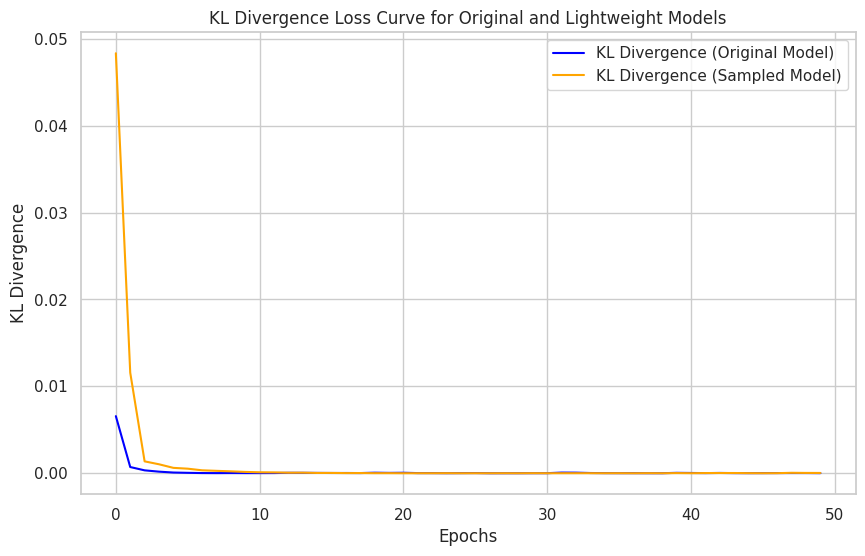

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.stats import entropy, gaussian_kde

# Step 1: Data Simulation
np.random.seed(42)  # For reproducibility
num_observations = 10000
num_features = 10  # 10 appliances
data = np.random.rand(num_observations, num_features) * 100  # Random data between 0 and 100

# Total hourly consumption as the sum of all appliances
total_consumption = data.sum(axis=1, keepdims=True)

# Standardize features
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)
total_consumption_scaled = scaler.fit_transform(total_consumption)

# Step 2: Sample Data
sample_indices = np.random.choice(np.arange(num_observations), size=3000, replace=False)
data_sampled = data_scaled[sample_indices]
total_sampled = total_consumption_scaled[sample_indices]

# Step 3: LSTM Model Setup
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        return out

# KL Divergence Calculation
def calculate_kl_divergence(p, q):
    p_density = gaussian_kde(p)
    q_density = gaussian_kde(q)
    x = np.linspace(min(p.min(), q.min()), max(p.max(), q.max()), 1000)
    p_pdf = p_density(x)
    q_pdf = q_density(x)
    return entropy(p_pdf, q_pdf)

def train_model_with_kl(data, targets, model, epochs=10, batch_size=64):
    model.train()
    train_data = TensorDataset(torch.Tensor(data), torch.Tensor(targets))
    train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    kl_divergences = []

    for epoch in range(epochs):
        model_outputs = []
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            model_outputs.extend(outputs.detach().numpy())

        kl_div = calculate_kl_divergence(np.array(model_outputs).flatten(), targets.flatten())
        kl_divergences.append(kl_div)
        print(f'Epoch {epoch + 1}, Loss: {loss.item()}, KL Divergence: {kl_div}')

    return kl_divergences

# Prepare data for LSTM
X_train, X_test, y_train, y_test = train_test_split(data_scaled, total_consumption_scaled, test_size=0.2, random_state=42)
X_sample_train, X_sample_test, y_sample_train, y_sample_test = train_test_split(data_sampled, total_sampled, test_size=0.2, random_state=42)

# Initialize models
model_original = LSTMModel(input_dim=num_features, hidden_dim=50, num_layers=2, output_dim=1)
model_sampled = LSTMModel(input_dim=num_features, hidden_dim=50, num_layers=2, output_dim=1)

# Train models and calculate KL divergence over epochs
kl_divergence_original = train_model_with_kl(X_train.reshape(-1, 1, num_features), y_train, model_original, epochs=50)
kl_divergence_sampled = train_model_with_kl(X_sample_train.reshape(-1, 1, num_features), y_sample_train, model_sampled, epochs=50)

# Plot KL divergence for both models
plt.figure(figsize=(10, 6))
plt.plot(kl_divergence_original, label='KL Divergence (Original Model)', color='blue')
plt.plot(kl_divergence_sampled, label='KL Divergence (Sampled Model)', color='orange')
plt.title('KL Divergence Loss Curve for Original and Lightweight Models')
plt.xlabel('Epochs')
plt.ylabel('KL Divergence')
plt.legend()
plt.grid(True)
plt.show()


#Keeping structural dependencies and light weight model giving translated and rotated image of output of original model in similar envieonment

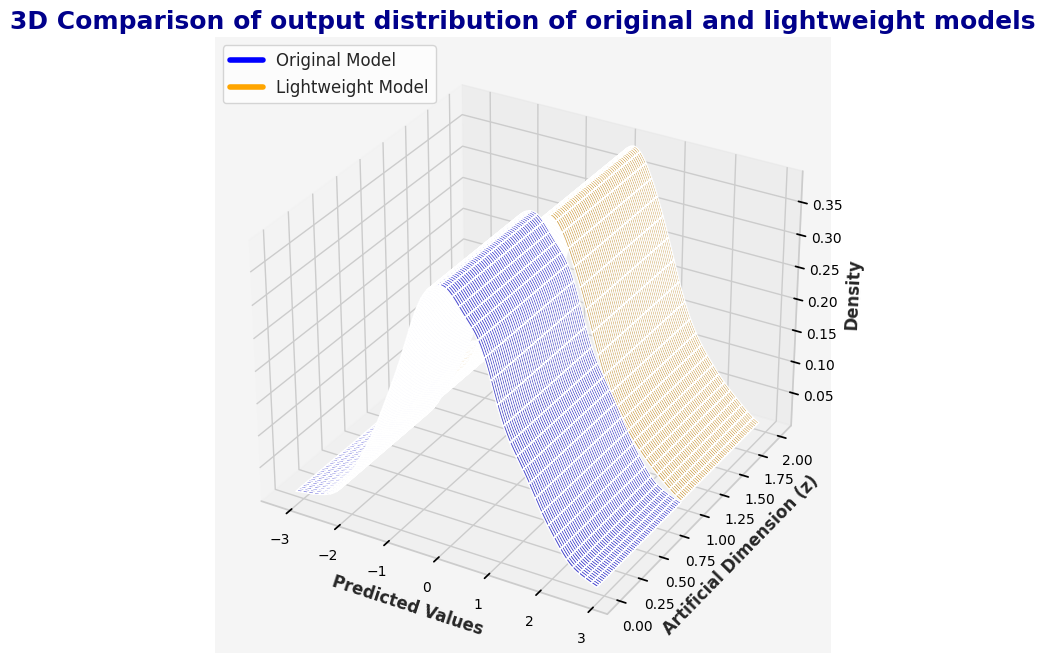

In [ ]:
# Step 5: 3D Solid KDE Distribution Projection with Meshgrid
def project_and_compare_3d_solid_kde(orig_preds, sample_preds):
    # Generate KDE for original and sampled predictions
    orig_kde = gaussian_kde(orig_preds)
    sample_kde = gaussian_kde(sample_preds)

    # Generate x-axis values
    x_vals = np.linspace(min(orig_preds.min(), sample_preds.min()),
                         max(orig_preds.max(), sample_preds.max()), 1000)

    # Compute the KDE for original and sampled
    orig_pdf = orig_kde(x_vals)
    sample_pdf = sample_kde(x_vals)

    # Meshgrid for artificial third dimension (z)
    X, Z = np.meshgrid(x_vals, np.linspace(0, 1, len(x_vals)))

    # Create 3D plot
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Create filled surface for original predictions
    ax.plot_surface(X, Z, np.tile(orig_pdf, (len(x_vals), 1)), color='blue', alpha=0.7, label='Original Model')

    # Create filled surface for sampled predictions
    ax.plot_surface(X, Z + 1, np.tile(sample_pdf, (len(x_vals), 1)), color='orange', alpha=0.7, label='Lightweight Model')

    # Additional cool-looking features
    ax.set_title('3D Comparison of output distribution of original and lightweight models', fontsize=18, weight='bold', color='darkblue')
    ax.set_xlabel('Predicted Values', fontsize=12, weight='bold')
    ax.set_ylabel('Artificial Dimension (z)', fontsize=12, weight='bold')
    ax.set_zlabel('Density', fontsize=12, weight='bold')

    # Grid and transparency for smooth aesthetics
    ax.grid(True, color='gray', linestyle='--', alpha=0.7)
    ax.set_facecolor('whitesmoke')

    # Customize ticks and fonts
    ax.tick_params(axis='both', which='major', labelsize=10, colors='black')
    # Custom legend (since plot_surface doesn't use labels)
    custom_lines = [plt.Line2D([0], [0], color='blue', lw=4),
                    plt.Line2D([0], [0], color='orange', lw=4)]
    ax.legend(custom_lines, ['Original Model', 'Lightweight Model'], loc='upper left', fontsize=12)

    plt.show()

    #plt.legend(fontsize=12, loc='upper left')

    plt.show()

# Apply 3D KDE projection with solid look
project_and_compare_3d_solid_kde(orig_preds, sample_preds)

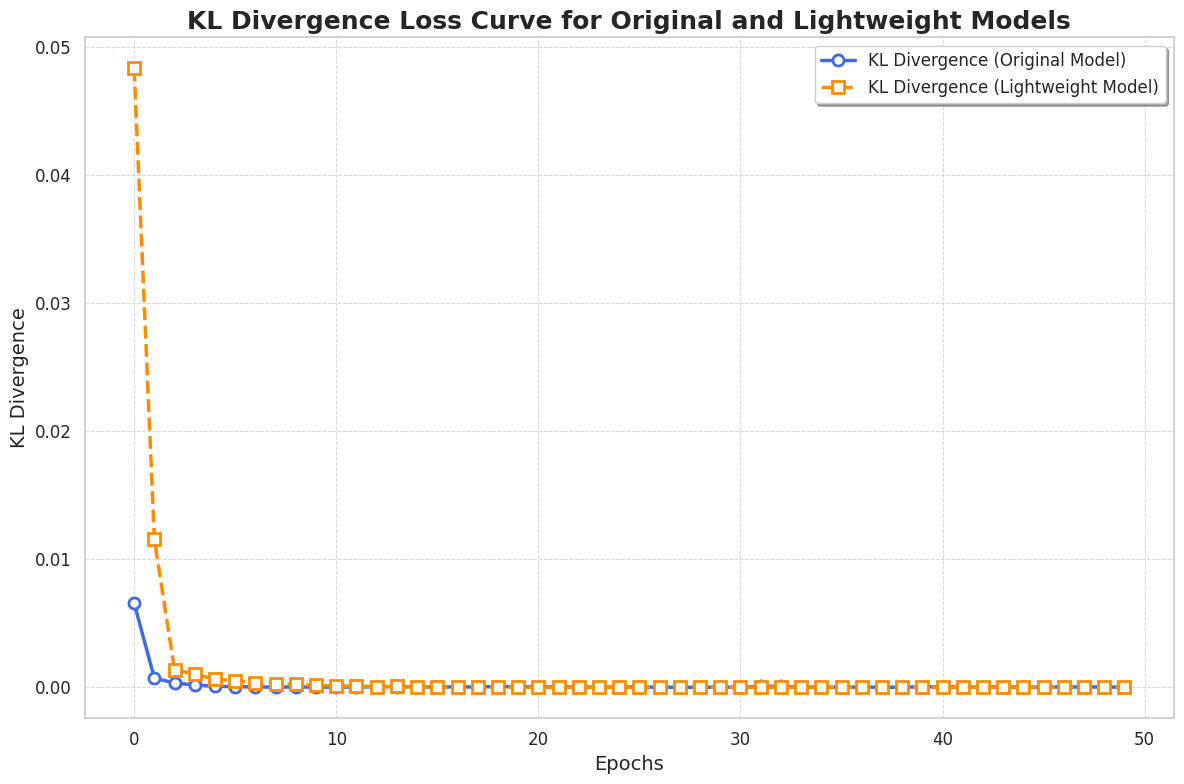

In [ ]:
# Enhanced Plot for KL Divergence
plt.figure(figsize=(12, 8))

# Plot for Original Model
plt.plot(
    kl_divergence_original,
    label='KL Divergence (Original Model)',
    color='royalblue',
    linestyle='-',
    linewidth=2.5,
    marker='o',
    markersize=8,
    markerfacecolor='white',
    markeredgewidth=2
)

# Plot for Sampled Model
plt.plot(
    kl_divergence_sampled,
    label='KL Divergence (Lightweight Model)',
    color='darkorange',
    linestyle='--',
    linewidth=2.5,
    marker='s',
    markersize=8,
    markerfacecolor='white',
    markeredgewidth=2
)

# Title and labels
plt.title('KL Divergence Loss Curve for Original and Lightweight Models', fontsize=18, fontweight='bold')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('KL Divergence', fontsize=14)

# Customize grid, legend, and axes
plt.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.8)
plt.legend(fontsize=12, loc='upper right', frameon=True, shadow=True)

# Adjust ticks
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Display plot
plt.tight_layout()
plt.show()


#ACC vs Pred of both model on their own test data

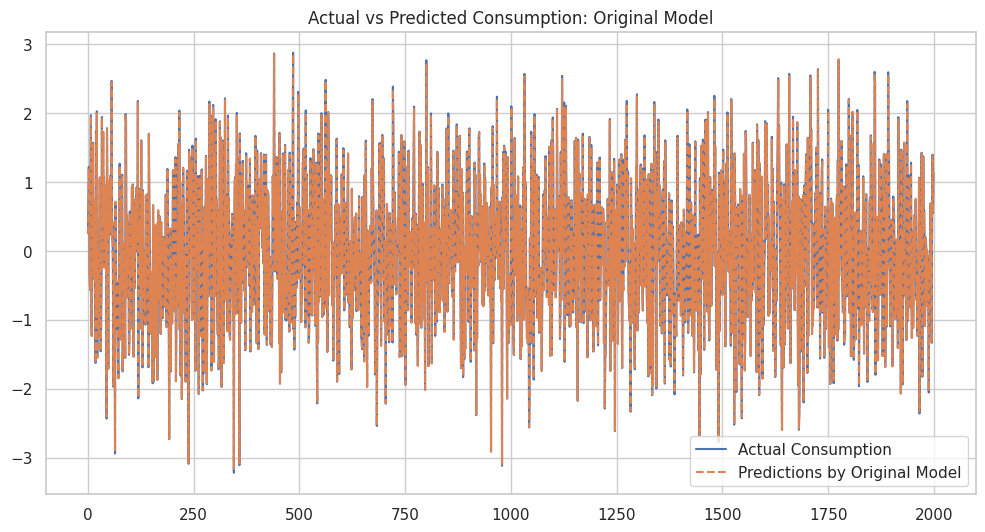

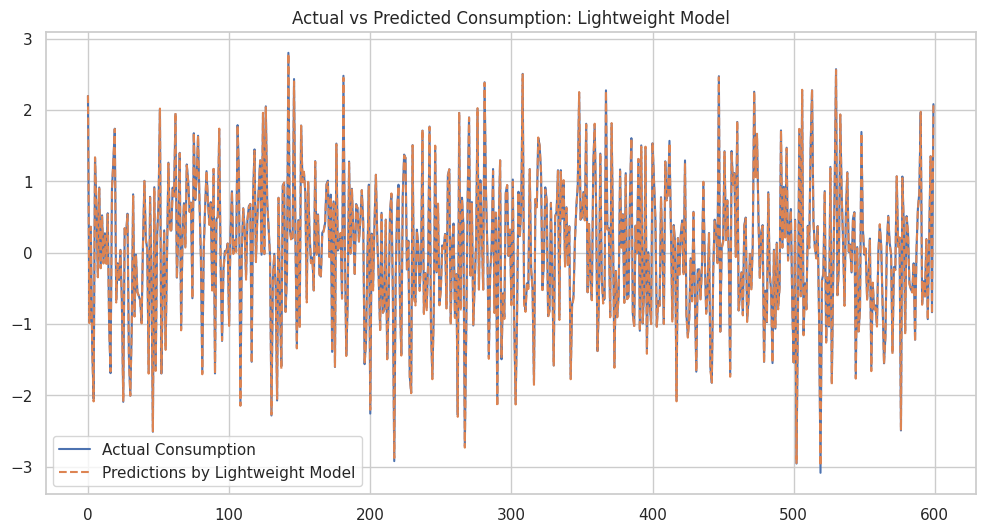

In [ ]:
# Plot accuracy vs predictions
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual Consumption')
plt.plot(orig_preds, label='Predictions by Original Model', linestyle='--')
plt.legend()
plt.title('Actual vs Predicted Consumption: Original Model')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(y_sample_test, label='Actual Consumption')
plt.plot(sample_preds, label='Predictions by Lightweight Model', linestyle='--')
plt.legend()
plt.title('Actual vs Predicted Consumption: Lightweight Model')
plt.show()



In [ ]:
# Step 4: Calculate Average Coordinate Distances
def calculate_distance(Y, F):
    """
    Calculates the average k-dimensional coordinate distance between the output vector Y and input features F.
    """
    n = F.shape[0]  # Number of observations
    distances = np.sum((Y - F) ** 2, axis=1)
    average_distance = np.mean(distances)
    return average_distance

# Step 5: Evaluate Models and Compute Distances
def evaluate_model(model, X_test):
    model.eval()
    with torch.no_grad():
        inputs = torch.Tensor(X_test)
        outputs = model(inputs).numpy().flatten()
    return outputs


In [ ]:
# Calculate distances
D2_final_original = calculate_distance(orig_preds.reshape(-1, 1), X_test)
D2_final_sampled = calculate_distance(sample_preds.reshape(-1, 1), X_sample_test)

print(f"Final Average Distance (Original): {D2_final_original}")
print(f"Final Average Distance (Sampled): {D2_final_sampled}")

# Calculate the difference in distances
distance_diff = abs(D2_final_original - D2_final_sampled)
print(f"Difference in Distances: {distance_diff}")

Final Average Distance (Original): 13.653252375881241
Final Average Distance (Sampled): 13.758168688537975
Difference in Distances: 0.10491631265673362


#Acc vs Pred on same data, lightweight  model keeping accuracy

Epoch 1/50, Loss: 0.0802462311424315
Epoch 2/50, Loss: 0.0008294018497690558
Epoch 3/50, Loss: 0.0003827813173411414
Epoch 4/50, Loss: 0.0003659285167814232
Epoch 5/50, Loss: 0.0003343965132953599
Epoch 6/50, Loss: 0.00030729045742191376
Epoch 7/50, Loss: 0.00013913702065474355
Epoch 8/50, Loss: 0.00010435303852136712
Epoch 9/50, Loss: 0.00010540723853046074
Epoch 10/50, Loss: 0.00017738451703917235
Epoch 11/50, Loss: 0.000618197905481793
Epoch 12/50, Loss: 0.0008713371279882267
Epoch 13/50, Loss: 0.0003978999868850224
Epoch 14/50, Loss: 0.0001795999050955288
Epoch 15/50, Loss: 0.0003530311416834593
Epoch 16/50, Loss: 0.0003752402862883173
Epoch 17/50, Loss: 0.00021532303039566614
Epoch 18/50, Loss: 0.0012005124132847414
Epoch 19/50, Loss: 0.0005882867722539231
Epoch 20/50, Loss: 0.00021571453276555985
Epoch 21/50, Loss: 0.000124124744485016
Epoch 22/50, Loss: 0.00023063787183491514
Epoch 23/50, Loss: 0.00023779811029089616
Epoch 24/50, Loss: 0.0011534626456559637
Epoch 25/50, Loss: 0.

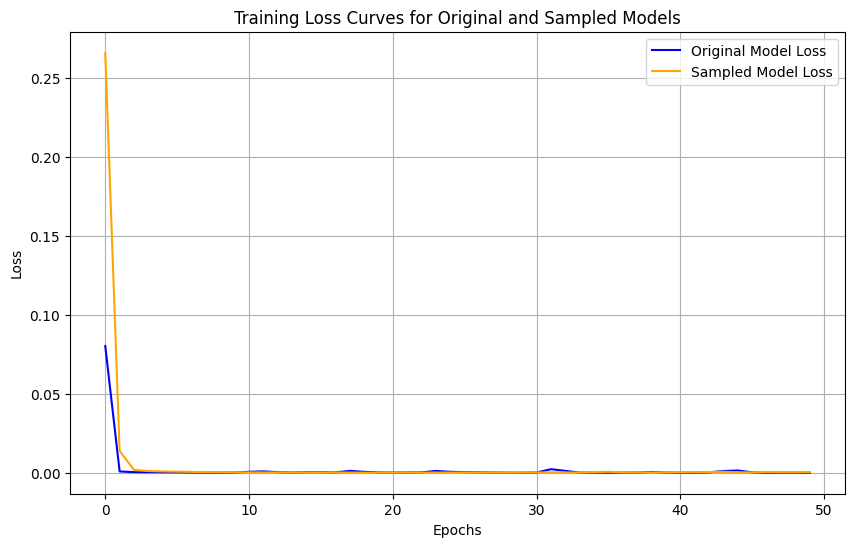

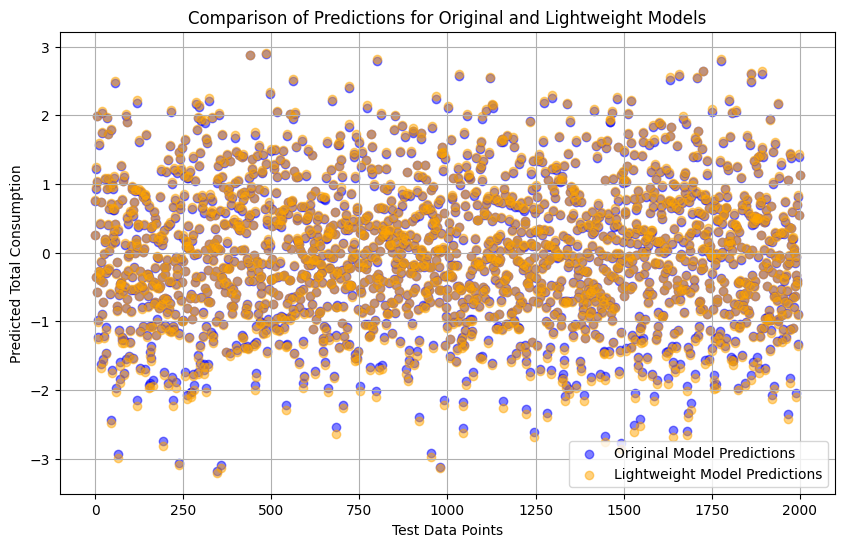

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# Step 1: Data Simulation
np.random.seed(42)  # For reproducibility
num_observations = 10000
num_features = 10  # 10 appliances
data = np.random.rand(num_observations, num_features) * 100  # Random data between 0 and 100

# Total hourly consumption as the sum of all appliances
total_consumption = data.sum(axis=1, keepdims=True)

# Standardize features
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)
total_consumption_scaled = scaler.fit_transform(total_consumption)

# Step 2: Sample Data (Maintain uniform test split for both models)
sample_indices = np.random.choice(np.arange(num_observations), size=3000, replace=False)
data_sampled = data_scaled[sample_indices]
total_sampled = total_consumption_scaled[sample_indices]

# Step 3: LSTM Model Setup
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        return out

# Step 4: Training the Model and Recording Losses
def train_model(data, targets, model, epochs=50, batch_size=64):
    model.train()
    train_data = TensorDataset(torch.Tensor(data), torch.Tensor(targets))
    train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    losses = []

    for epoch in range(epochs):
        epoch_loss = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        losses.append(epoch_loss / len(train_loader))
        print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss / len(train_loader)}')

    return losses

# Step 5: Evaluate Model on the same Test Data for both models
def evaluate_model(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        predictions = model(torch.Tensor(X_test)).numpy().flatten()
    mse = mean_squared_error(y_test, predictions)
    return mse, predictions

# Prepare data for LSTM (Ensure uniform test data across both models)
X_train, X_test, y_train, y_test = train_test_split(data_scaled, total_consumption_scaled, test_size=0.2, random_state=42)
X_sample_train, X_sample_test, y_sample_train, y_sample_test = train_test_split(data_sampled, total_sampled, test_size=0.2, random_state=42)

# Initialize models
model_original = LSTMModel(input_dim=num_features, hidden_dim=50, num_layers=2, output_dim=1)
model_sampled = LSTMModel(input_dim=num_features, hidden_dim=50, num_layers=2, output_dim=1)

# Train models and record losses
losses_original = train_model(X_train.reshape(-1, 1, num_features), y_train, model_original, epochs=50)
losses_sampled = train_model(X_sample_train.reshape(-1, 1, num_features), y_sample_train, model_sampled, epochs=50)

# Step 6: Evaluate models on same test set
mse_original, orig_preds = evaluate_model(model_original, X_test.reshape(-1, 1, num_features), y_test)
mse_sampled, sample_preds = evaluate_model(model_sampled, X_test.reshape(-1, 1, num_features), y_test)  # Evaluate both on same test set

print(f'MSE of Original Model: {mse_original}')
print(f'MSE of Sampled Model: {mse_sampled}')

# Step 7: Plot Loss Curves
plt.figure(figsize=(10, 6))
plt.plot(losses_original, label='Original Model Loss', color='blue')
plt.plot(losses_sampled, label='Sampled Model Loss', color='orange')
plt.title('Training Loss Curves for Original and Sampled Models')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Step 8: Plot Prediction Comparison (with same test data evaluation)
plt.figure(figsize=(10, 6))
plt.scatter(range(len(orig_preds)), orig_preds, label='Original Model Predictions', color='blue', alpha=0.5)
plt.scatter(range(len(sample_preds)), sample_preds, label='Lightweight Model Predictions', color='orange', alpha=0.5)
plt.title('Comparison of Predictions for Original and Lightweight Models')
plt.xlabel('Test Data Points')
plt.ylabel('Predicted Total Consumption')
plt.legend()
plt.grid(True)
plt.show()


#Performance Comparision with all metric


Epoch 1/50, Loss: 0.0898734273109585
Epoch 2/50, Loss: 0.0008128192196600139
Epoch 3/50, Loss: 0.0005115856834454462
Epoch 4/50, Loss: 0.0003919936799793504
Epoch 5/50, Loss: 0.00020724222797434777
Epoch 6/50, Loss: 0.0001692912064027041
Epoch 7/50, Loss: 0.00022341526745003648
Epoch 8/50, Loss: 0.00029867966411984526
Epoch 9/50, Loss: 0.00013869947349303403
Epoch 10/50, Loss: 0.00013644271594239398
Epoch 11/50, Loss: 0.0002368198279873468
Epoch 12/50, Loss: 0.0001621922609047033
Epoch 13/50, Loss: 0.0009797107559279539
Epoch 14/50, Loss: 0.001355682180263102
Epoch 15/50, Loss: 0.00023340786760672928
Epoch 16/50, Loss: 0.00020697540551191195
Epoch 17/50, Loss: 0.0004394935166928917
Epoch 18/50, Loss: 0.0003486388609162532
Epoch 19/50, Loss: 0.00023963133888901212
Epoch 20/50, Loss: 0.0003041315261798445
Epoch 21/50, Loss: 0.00020873564103385435
Epoch 22/50, Loss: 0.0006091959109762684
Epoch 23/50, Loss: 0.00024415498555754314
Epoch 24/50, Loss: 0.0001379128419794142
Epoch 25/50, Loss: 

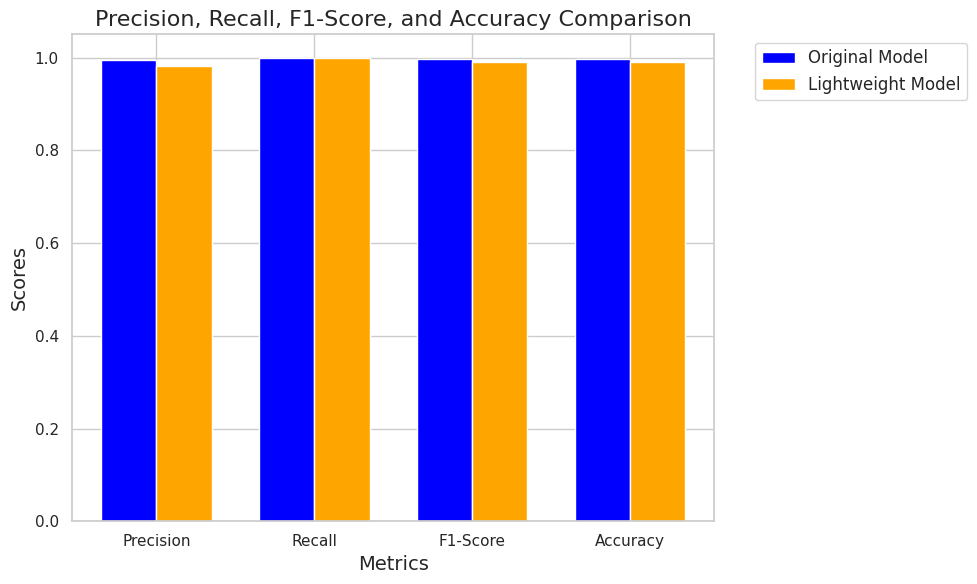

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report
import seaborn as sns

# Step 1: Data Simulation
np.random.seed(42)  # For reproducibility
num_observations = 10000
num_features = 10  # 10 appliances
data = np.random.rand(num_observations, num_features) * 100  # Random data between 0 and 100

# Total hourly consumption as the sum of all appliances
total_consumption = data.sum(axis=1, keepdims=True)

# Standardize features
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)
total_consumption_scaled = scaler.fit_transform(total_consumption)

# Step 2: Sample Data
sample_indices = np.random.choice(np.arange(num_observations), size=3000, replace=False)
data_sampled = data_scaled[sample_indices]
total_sampled = total_consumption_scaled[sample_indices]

# Step 3: LSTM Model Setup
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        return out

# Step 4: Training the Model and Recording Losses
def train_model(data, targets, model, epochs=50, batch_size=64):
    model.train()
    train_data = TensorDataset(torch.Tensor(data), torch.Tensor(targets))
    train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    losses = []

    for epoch in range(epochs):
        epoch_loss = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        losses.append(epoch_loss / len(train_loader))
        print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss / len(train_loader)}')

    return losses

# Step 5: Convert Regression Output to Binary Classification
def binarize_output(predictions, threshold=0):
    return np.where(predictions > threshold, 1, 0)

# Step 6: Evaluate Model on Test Data
def evaluate_model(model, X_test, y_test, threshold=0):
    model.eval()
    with torch.no_grad():
        predictions = model(torch.Tensor(X_test)).numpy().flatten()
    y_true_bin = binarize_output(y_test, threshold=threshold)
    predictions_bin = binarize_output(predictions, threshold=threshold)

    precision = precision_score(y_true_bin, predictions_bin)
    recall = recall_score(y_true_bin, predictions_bin)
    f1 = f1_score(y_true_bin, predictions_bin)
    accuracy = accuracy_score(y_true_bin, predictions_bin)

    return precision, recall, f1, accuracy, y_true_bin, predictions_bin

# Prepare data for LSTM
X_train, X_test, y_train, y_test = train_test_split(data_scaled, total_consumption_scaled, test_size=0.2, random_state=42)
X_sample_train, X_sample_test, y_sample_train, y_sample_test = train_test_split(data_sampled, total_sampled, test_size=0.2, random_state=42)

# Initialize models
model_original = LSTMModel(input_dim=num_features, hidden_dim=50, num_layers=2, output_dim=1)
model_sampled = LSTMModel(input_dim=num_features, hidden_dim=50, num_layers=2, output_dim=1)

# Train models and record losses
train_model(X_train.reshape(-1, 1, num_features), y_train, model_original, epochs=50)
train_model(X_sample_train.reshape(-1, 1, num_features), y_sample_train, model_sampled, epochs=50)

# Step 7: Evaluate both models for Precision, Recall, F1-Score, and Accuracy
threshold = 0  # Set an appropriate threshold based on the distribution of total consumption
precision_original, recall_original, f1_original, accuracy_original, y_true_bin_orig, pred_bin_orig = evaluate_model(model_original, X_test.reshape(-1, 1, num_features), y_test, threshold)
precision_sampled, recall_sampled, f1_sampled, accuracy_sampled, y_true_bin_sampled, pred_bin_sampled = evaluate_model(model_sampled, X_sample_test.reshape(-1, 1, num_features), y_sample_test, threshold)

# Print classification report for more insights
print("Original Model Classification Report")
print(classification_report(y_true_bin_orig, pred_bin_orig))
print("Sampled Model Classification Report")
print(classification_report(y_true_bin_sampled, pred_bin_sampled))

# Step 8: Plot Precision, Recall, F1-Score, and Accuracy for both models
metrics = ['Precision', 'Recall', 'F1-Score', 'Accuracy']
original_scores = [precision_original, recall_original, f1_original, accuracy_original]
sampled_scores = [precision_sampled, recall_sampled, f1_sampled, accuracy_sampled]

plt.figure(figsize=(10, 6))
bar_width = 0.35
index = np.arange(len(metrics))

plt.bar(index, original_scores, bar_width, label='Original Model', color='blue')
plt.bar(index + bar_width, sampled_scores, bar_width, label='Lightweight Model', color='orange')

plt.xlabel('Metrics', fontsize=14)
plt.ylabel('Scores', fontsize=14)
plt.title('Precision, Recall, F1-Score, and Accuracy Comparison', fontsize=16)
plt.xticks(index + bar_width / 2, metrics)
plt.legend()
plt.grid(True)
# Adjust the legend to be outside the plot area
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)

plt.tight_layout()
plt.show()


#ExCIR with MCIR

Training Original Model:
Epoch 1/50, Loss: 0.08328555368632078
Epoch 2/50, Loss: 0.0011096782060340048
Epoch 3/50, Loss: 0.0007597824365366251
Epoch 4/50, Loss: 0.0005786892850883305
Epoch 5/50, Loss: 0.0006139718831982464
Epoch 6/50, Loss: 0.0004933499363251031
Epoch 7/50, Loss: 0.0005138412672095001
Epoch 8/50, Loss: 0.0005698525427142158
Epoch 9/50, Loss: 0.0007071754492353648
Epoch 10/50, Loss: 0.0005568902418017388
Epoch 11/50, Loss: 0.0006094655562192202
Epoch 12/50, Loss: 0.0005523823847761377
Epoch 13/50, Loss: 0.0007629918339662254
Epoch 14/50, Loss: 0.0009782612188719213
Epoch 15/50, Loss: 0.0007020713908132166
Epoch 16/50, Loss: 0.0005102407282683998
Epoch 17/50, Loss: 0.0005496515219565481
Epoch 18/50, Loss: 0.0005993980960920454
Epoch 19/50, Loss: 0.0006149141131900251
Epoch 20/50, Loss: 0.0006031743751373142
Epoch 21/50, Loss: 0.0008416884173639118
Epoch 22/50, Loss: 0.000878016013186425
Epoch 23/50, Loss: 0.0005134852004703135
Epoch 24/50, Loss: 0.00047866217023693027
Ep

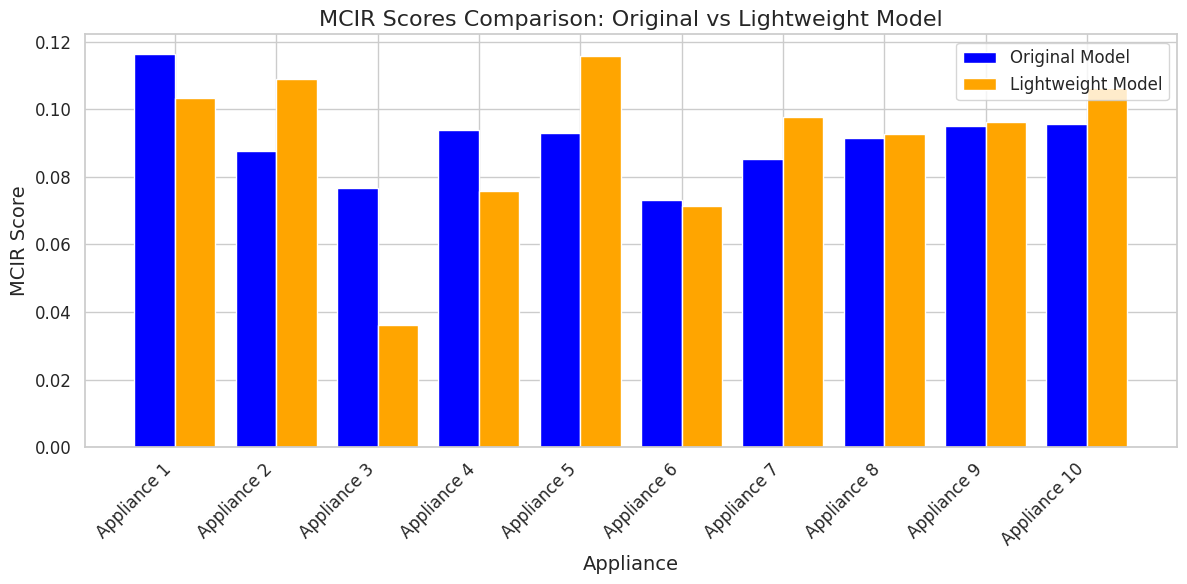

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Set seaborn style for a better-looking plot
sns.set(style='whitegrid')

# Step 1: Data Simulation with Non-linear Relationships Based on MCIR Proportionality
np.random.seed(42)  # For reproducibility
num_observations = 10000
num_features = 10  # 10 appliances

# Generate base random data for features
data = np.random.rand(num_observations, num_features) * 100

# Non-linear dependencies among appliances using MCIR proportionality
# Let's assume half the features have a direct relationship, half have an inverse relationship

def apply_nonlinear_relationship(data, mcir_scores):
    for i in range(num_features):
        if i < num_features // 2:
            # Direct relationship with MCIR: Y changes directly with the feature
            data[:, i] = data[:, i] * mcir_scores[i] + np.random.rand(num_observations) * 0.1
        else:
            # Inverse relationship with MCIR: Y changes inversely with the feature
            data[:, i] = data[:, i] * (1 / (mcir_scores[i] + 1e-6)) + np.random.rand(num_observations) * 0.1
    return data

# Calculate MCIR for the initial random data (will be used to control the relationship)
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)
total_consumption = data.sum(axis=1, keepdims=True)  # Sum of all features as the target
total_consumption_scaled = scaler.fit_transform(total_consumption)

mcir_scores_initial = mutual_info_regression(data_scaled, total_consumption_scaled.flatten())
data_nonlinear = apply_nonlinear_relationship(data, mcir_scores_initial)

# Standardize the non-linear data
data_nonlinear_scaled = scaler.fit_transform(data_nonlinear)

# Step 2: Sample Data for Lightweight Model
sample_indices = np.random.choice(np.arange(num_observations), size=3000, replace=False)
data_sampled = data_nonlinear_scaled[sample_indices]
total_sampled = total_consumption_scaled[sample_indices]

# Step 3: Define LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        return out

# Step 4: Training the Model and Recording Losses
def train_model(data, targets, model, epochs=50, batch_size=64):
    model.train()
    train_data = TensorDataset(torch.Tensor(data), torch.Tensor(targets))
    train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    losses = []

    for epoch in range(epochs):
        epoch_loss = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        losses.append(epoch_loss / len(train_loader))
        print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss / len(train_loader)}')

    return losses

# Step 5: Evaluate Model on Test Data
def evaluate_model(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        predictions = model(torch.Tensor(X_test)).numpy().flatten()
    mse = mean_squared_error(y_test, predictions)
    return mse, predictions

# Prepare Data for Training and Testing
X_train, X_test, y_train, y_test = train_test_split(data_nonlinear_scaled, total_consumption_scaled, test_size=0.2, random_state=42)
X_sample_train, X_sample_test, y_sample_train, y_sample_test = train_test_split(data_sampled, total_sampled, test_size=0.2, random_state=42)

# Initialize the LSTM Models for Original and Lightweight Data
model_original = LSTMModel(input_dim=num_features, hidden_dim=50, num_layers=2, output_dim=1)
model_lightweight = LSTMModel(input_dim=num_features, hidden_dim=50, num_layers=2, output_dim=1)

# Train both models
print("Training Original Model:")
losses_original = train_model(X_train.reshape(-1, 1, num_features), y_train, model_original, epochs=50)

print("\nTraining Lightweight Model:")
losses_lightweight = train_model(X_sample_train.reshape(-1, 1, num_features), y_sample_train, model_lightweight, epochs=50)

# Evaluate models
mse_original, predictions_original = evaluate_model(model_original, X_test.reshape(-1, 1, num_features), y_test)
mse_lightweight, predictions_lightweight = evaluate_model(model_lightweight, X_sample_test.reshape(-1, 1, num_features), y_sample_test)

print(f"\nMSE (Original Model): {mse_original}")
print(f"MSE (Lightweight Model): {mse_lightweight}")

# Step 6: Calculate Mutual Information for MCIR
def calculate_mcir(X, y):
    # Compute mutual information between each feature and the target
    mutual_info = mutual_info_regression(X, y.flatten())

    # Joint mutual information for all features together
    joint_mutual_info = mutual_info_regression(X, y.flatten(), discrete_features=False).sum()

    # Calculate MCIR for each feature
    mcir_scores = mutual_info / (mutual_info + joint_mutual_info)
    return mcir_scores

# Calculate MCIR for both models
mcir_scores_original = calculate_mcir(data_nonlinear_scaled, total_consumption_scaled)
mcir_scores_lightweight = calculate_mcir(data_sampled, total_sampled)

# Feature names
feature_names = [f'Appliance {i}' for i in range(1, num_features + 1)]

# Step 7: Visualize MCIR scores for both models
plt.figure(figsize=(12, 6))

# Plot MCIR scores for original model
plt.bar(np.arange(1, num_features + 1) - 0.2, mcir_scores_original, width=0.4, label='Original Model', color='blue')

# Plot MCIR scores for lightweight model
plt.bar(np.arange(1, num_features + 1) + 0.2, mcir_scores_lightweight, width=0.4, label='Lightweight Model', color='orange')

# Add labels and title
plt.xlabel('Appliance', fontsize=14)
plt.ylabel('MCIR Score', fontsize=14)
plt.title('MCIR Scores Comparison: Original vs Lightweight Model', fontsize=16)

# Rotate the x-axis labels for better readability
plt.xticks(np.arange(1, num_features + 1), feature_names, fontsize=12, rotation=45, ha="right")

# Adjust the layout to prevent label cut-off
plt.tight_layout()

# Add grid, legend, and ticks with appliance names
plt.yticks(fontsize=12)
plt.legend(fontsize=12, loc='upper right')
plt.grid(True)

# Show the plot
plt.show()


In [ ]:
import numpy as np
import pandas as pd

# Set parameters
np.random.seed(42)
num_observations = 10000
num_features = 10

# Generate random data for features
data = np.random.rand(num_observations, num_features) * 100

# Use MCIR scores for applying the non-linear relationship
mcir_scores = np.random.rand(num_features)

# Introduce dependencies between features based on ExCIR
# Create correlation between some features
def create_feature_dependencies(data, mcir_scores):
    # Generate base feature values
    for i in range(num_features):
        if i < num_features // 2:
            # Direct dependency: features are directly related to the output
            data[:, i] = data[:, i] * mcir_scores[i] + np.random.rand(num_observations) * 0.1
        else:
            # Inverse dependency: features have an inverse relation
            data[:, i] = data[:, i] * (1 / (mcir_scores[i] + 1e-6)) + np.random.rand(num_observations) * 0.1

    # Now, apply inter-feature dependencies
    for i in range(1, num_features):
        # Each feature i is influenced by feature i-1 to introduce correlation
        data[:, i] += 0.5 * data[:, i - 1]

    return data

# Apply the non-linear relationships and inter-feature dependencies
data_nonlinear = create_feature_dependencies(data, mcir_scores)

# Create a DataFrame for better readability
df_nonlinear = pd.DataFrame(data_nonlinear, columns=[f'Appliance {i+1}' for i in range(num_features)])

# Display the first ten rows
print(df_nonlinear.head(10))


   Appliance 1  Appliance 2  Appliance 3  Appliance 4  Appliance 5  \
0    21.753571    61.046775    56.291925    57.695283    34.579721   
1     1.282532    51.762807    55.147373    38.142385    25.748077   
2    35.559673    25.134237    22.836251    29.534996    31.508765   
3    35.329041    26.697490    15.706334    54.746340    62.658782   
4     7.102980    29.693644    16.088390    52.992174    36.005421   
5    56.379254    69.102402    67.607178    77.988601    60.849819   
6    22.628092    25.684015    41.971694    38.589890    29.629352   
7    44.886837    32.966050    16.694373    48.647893    50.229916   
8    50.180758    58.007226    40.704659    23.548154    23.225318   
9     6.962657    41.092330    47.257718    51.319116    53.819161   

   Appliance 6  Appliance 7  Appliance 8  Appliance 9  Appliance 10  
0    41.063878    27.510050   123.927433   238.419353    258.274903  
1    40.774500    56.854189    95.138942   174.381712    144.391076  
2   135.171567    9

In [ ]:
!pip install torchviz


  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4132 sha256=15f6df5125585e4c0320bfa050856040720094aa7f7fd12a3ce8839538b0c7a0
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


In [ ]:
import torch
import torch.nn as nn
from torchviz import make_dot

# Define the LSTMModel class (same as in your code)
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        return out

# Instantiate your model
input_dim = 10  # Example input dimension (features)
hidden_dim = 50
num_layers = 2
output_dim = 1
model = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)

# Create a dummy input tensor
x = torch.randn(64, 1, input_dim)  # Example batch size of 64, sequence length of 1

# Get the model's output and generate graph
y = model(x)
dot = make_dot(y, params=dict(model.named_parameters()))

# Render the model graph
dot.format = 'png'
dot.render('lstm_model_graph')


'lstm_model_graph.png'

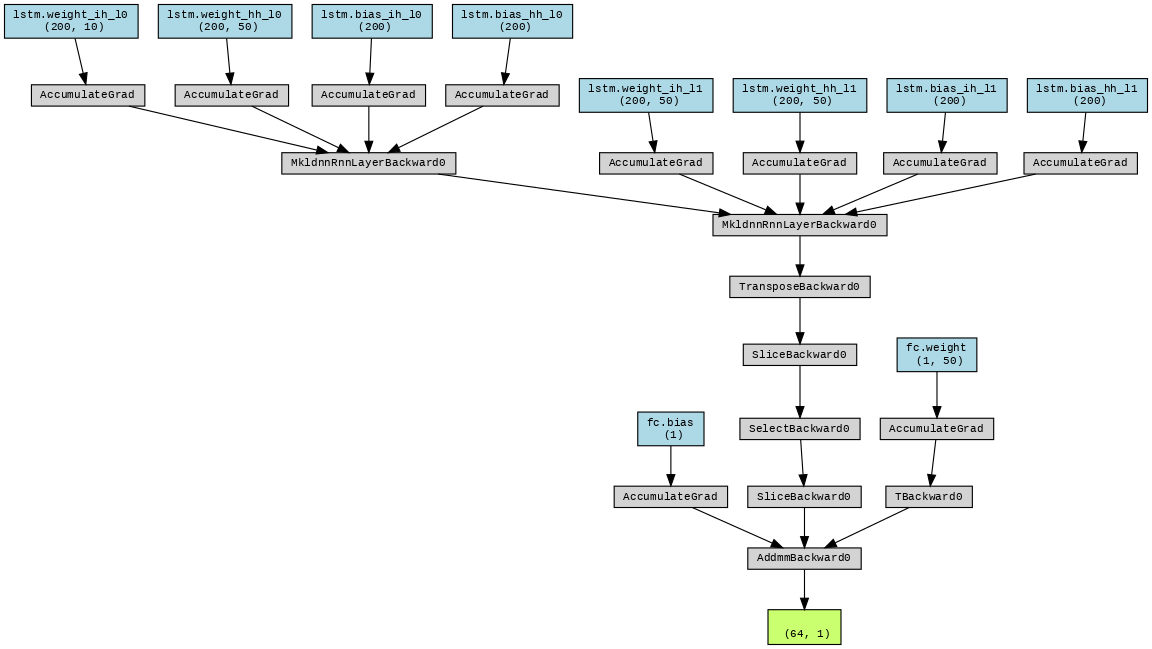

In [ ]:
from IPython.display import Image

# Display the graph within the notebook or environment
dot.render('lstm_model_graph', format='png')
Image('lstm_model_graph.png')


In [ ]:
from graphviz import Digraph

# Create a Digraph object
flowchart = Digraph(comment='Algorithm Flowchart')

# Add nodes
flowchart.node('A', 'Start')
flowchart.node('B', 'Data Simulation with Non-linear Dependencies')
flowchart.node('C', 'Sample Data')
flowchart.node('D', 'Train Original LSTM Model')
flowchart.node('E', 'Train Lightweight LSTM Model')
flowchart.node('F', 'Evaluate Models and Record Losses')
flowchart.node('G', 'Calculate Mutual Information')
flowchart.node('H', 'Visualize MCIR Scores')
flowchart.node('I', 'Compare MCIR Scores (Original vs Lightweight)')
flowchart.node('J', 'End')

# Add edges (connections)
flowchart.edges(['AB', 'BC', 'CD', 'CE', 'DF', 'EF', 'FG', 'GH', 'HI', 'IJ'])

# Save and render the flowchart
flowchart.render('algorithm_flowchart', format='png', view=True)


'algorithm_flowchart.png'

In [ ]:
from graphviz import Digraph

# Create a Digraph object
flowchart = Digraph(comment='Detailed Algorithm Flowchart')

# Add nodes with more detailed steps
flowchart.node('A', 'Start')
flowchart.node('B', 'Data Simulation with Non-linear Dependencies')
flowchart.node('C', 'Sample Data for Both Models')
flowchart.node('D', 'Train Original LSTM Model')
flowchart.node('E', 'Train Lightweight LSTM Model')
flowchart.node('F', 'Evaluate Models: Accuracy and Loss')
flowchart.node('G', 'Calculate Mutual Information (MCIR)')
flowchart.node('H', 'Visualize MCIR Scores for Each Feature')
flowchart.node('I', 'Compare Accuracy (Original vs Lightweight)')
flowchart.node('J', 'Compare Explainability (Original vs Lightweight)')
flowchart.node('K', 'Balance Accuracy and Explainability')
flowchart.node('L', 'Choose Optimal Model (Accuracy vs Explainability)')
flowchart.node('M', 'End')

# Add edges (connections)
flowchart.edge('A', 'B')
flowchart.edge('B', 'C', label='Non-linear Relationships Added')
flowchart.edge('C', 'D', label='Original Model Data')
flowchart.edge('C', 'E', label='Lightweight Model Data')
flowchart.edge('D', 'F', label='Accuracy and Loss Measured')
flowchart.edge('E', 'F', label='Accuracy and Loss Measured')
flowchart.edge('F', 'G', label='Use Model Predictions')
flowchart.edge('G', 'H', label='Visualize MCIR')
flowchart.edge('F', 'I', label='Compare Accuracy')
flowchart.edge('H', 'J', label='Compare Explainability')
flowchart.edge('I', 'K', label='Balance Accuracy')
flowchart.edge('J', 'K', label='Balance Explainability')
flowchart.edge('K', 'L', label='Optimal Trade-off')
flowchart.edge('L', 'M', label='End')

# Save and render the flowchart
flowchart.render('detailed_algorithm_flowchart', format='png', view=True)


'detailed_algorithm_flowchart.png'